In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader


# Performance measure
from ignite.metrics import SSIM
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

# 3D-UNet model
from pytorch3dunet.unet3d import model

from train_utils import predictions, LoadData

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32)

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Loading test data

During preprocessing, the test data was saved in a spesific folder.

In [ ]:
test_img_path = '../Preprocessing/preprocessed_img_test'
test_kspace_path = '../Preprocessing/preprocessed_kspace_test'

test_data = LoadData(test_kspace_path, test_img_path, datatype='test')

set_seed(42)
batch_size = 1
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

### Initializing 3D-UNet with the weights from the best performing model on validation data

The model gets initialized with the weights from the best performing model from the model selection.

In [ ]:
best_model = model.UNet3D(in_channels=2, out_channels=1, num_groups=8, is_segmentation=False)

# Loading checkpoint from path where the correct weights are saved
checkpoint = torch.load('./3D_model_weights/lr5e-4_wd1e-3_do04/model_lr0.0005_wd0.001_do0.4_epoch30.pth', map_location=device, weights_only=True)

best_model.load_state_dict(checkpoint['model_state_dict'])

# Setting model in evaluation mode
best_model.eval()

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 2, eps=1e-05, affine=True)
          (conv): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
     

### Generating predictions on test data

In [ ]:
best_model.to(device=device)

# Generating predictions
preds, true = predictions(best_model, test_loader)

### Plotting predictions on test data

Plotting predictions on test data to evaluate the generalization ability of the selected model. Only plotting the first time point (index 0) and slice number 85.

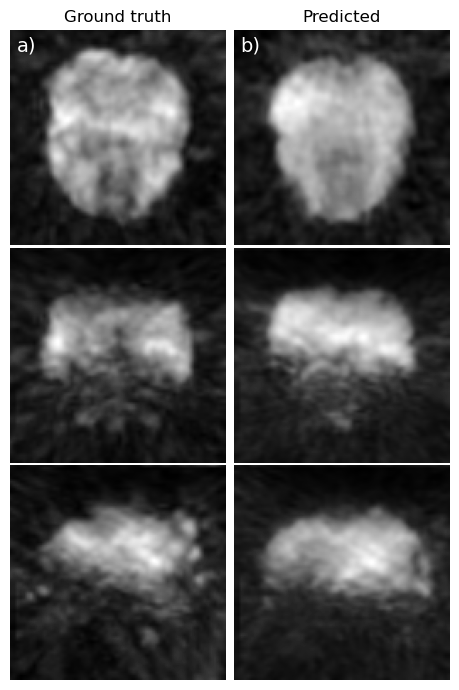

In [ ]:
# Selecting the first time point and moving tensors to CPU
preds_cpu = preds[0].cpu()
true_cpu = true[0].cpu()

# Removing batch and channel dimension
preds0= preds_cpu.squeeze(0,1)
true0= true_cpu.squeeze(0,1)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize =(5,7))

i = 85

ax[0,0].imshow(np.rot90(true0[:,:,i]), cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')
ax[0,0].text(15,3,'a)', ha='right', va='top', fontsize=14, color='white')

ax[0,1].imshow(np.rot90(preds0[:,:,i]), cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('Predicted')
ax[0,1].text(15,3,'b)', ha='right', va='top', fontsize=14, color='white')

ax[1,0].imshow(np.rot90(true0[:,i,:]), cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(np.rot90(preds0[:,i,:]), cmap='gray')
ax[1,1].axis('off')

ax[2,0].imshow(np.rot90(true0[i,:,:]), cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(np.rot90(preds0[i,:,:]), cmap='gray')
ax[2,1].axis('off')
plt.tight_layout()

plt.subplots_adjust( hspace=0.01, wspace=-0.09)
plt.show()

### Calculating performance measurements

Calculating MAE, MSE and SSIM on the predictions on test data, for all time points. Printing the mean value and standard deviation.

In [ ]:
def calc_MAE(preds, label):
    mae = MeanAbsoluteError()
    return mae(preds, label)

def calc_MSE(preds, label):
    mse = MeanSquaredError()
    return mse(preds, label)


def calc_SSIM_eval(preds, true):
    metric = SSIM(data_range=1)
    metric.update((preds, true))
    ssim_value = metric.compute()
    return ssim_value

ssim_list = []
mse_list = []
mae_list = []


# Looping over the number of time points (52) in predictions
for i in range(len(preds)):
    
    # Removing the channel dimension
    current_pred = preds[i].squeeze(0).cpu() 
    current_true = true[i].squeeze(0).cpu()

    ssim_val = calc_SSIM_eval(current_pred, current_true)
    ssim_list.append(ssim_val)

    mse_val = calc_MSE(current_pred, current_true)
    mse_list.append(mse_val)
    
    mae_val = calc_MAE(current_pred, current_true)
    mae_list.append(mae_val)

In [41]:
print(f'Mean SSIM: {np.mean(ssim_list)}')
print(f'Std SSIM: {np.std(ssim_list)}')
print(f'Mean MSE: {np.mean(mse_list)}')
print(f'Std MSE: {np.std(mse_list)}')
print(f'Mean MAE: {np.mean(mae_list)}')
print(f'Std MAE: {np.std(mae_list)}')

Mean SSIM: 0.6277947535276722
Std SSIM: 0.002675191726550322
Mean MSE: 0.0046330345794558525
Std MSE: 9.829510963754728e-05
Mean MAE: 0.04411081597208977
Std MAE: 0.00042618330917321146
